This kernel explores the Yelp dataset. Check out my Medium post here (need to insert link).

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud
from nltk.corpus import stopwords

Inspect all json files in the **Yelp** dataset:

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/Dataset_Agreement.pdf


Load *business* json file and convert into pandas dataframe:

In [3]:
business = []
with open('../input/yelp-dataset/yelp_academic_dataset_business.json') as fl:
    for i, line in enumerate(fl):
        business.append(json.loads(line)) #use 'loads' since line is string
df_business = pd.DataFrame(business)

# print the first five rows
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


Check the number of rows and columns:

In [4]:
df_business.shape

(209393, 14)

In [5]:
df_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

Business with missing *categories*:

In [6]:
df_business['categories'].isna().mean()

0.002502471429321897

In [7]:
df_business = df_business[df_business['categories'].notna()] #take out missing ones
df_business.shape

(208869, 14)

Find count values for each business categories:

In [8]:
cat_temp1 = ';'.join(df_business['categories'])
cat_temp2 = re.split(';|,', cat_temp1)
bus_cat_trim = [item.lstrip() for item in cat_temp2]
df_bus_cat = pd.DataFrame(bus_cat_trim,columns=['category'])

Plot top 10 categories

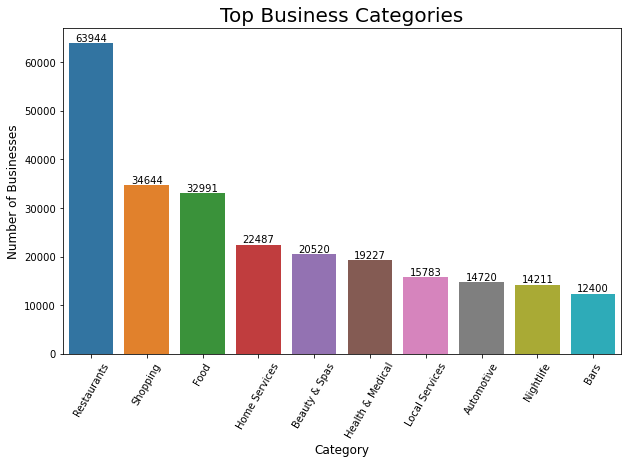

In [9]:
bus_cat_count = df_bus_cat.category.value_counts()
bus_cat_count = bus_cat_count.sort_values(ascending = False)
bus_cat_count = bus_cat_count.iloc[0:10]

# plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(bus_cat_count.index, bus_cat_count.values)
plt.title("Top Business Categories",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 60)
plt.ylabel('Number of Businesses', fontsize = 12)
plt.xlabel('Category', fontsize = 12)

#text labels
r = ax.patches
labels = bus_cat_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

Subset into restaurants

In [10]:
df_bus_res = df_business.loc[[i for i in df_business['categories'].index if re.search('Restaurants', df_business['categories'][i])]]

Geographical Visualization:

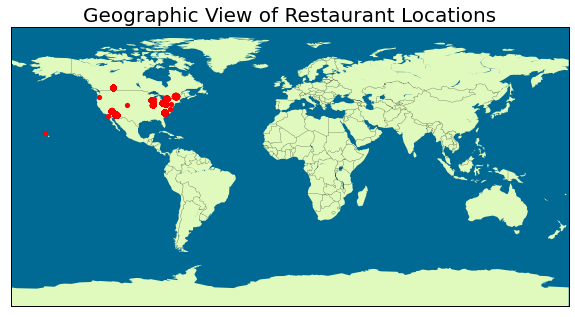

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.title("Geographic View of Restaurant Locations",fontsize = 20)
m=Basemap(projection='cyl', lon_0 = 0, lat_0=0, resolution='c')
m.fillcontinents(color='#e0fabe',lake_color='#006994')
m.drawmapboundary(fill_color='#006994') 
m.drawcountries(linewidth=0.2, color="black")
m_coords = m(df_bus_res["longitude"].tolist(), df_bus_res["latitude"].tolist())
m.scatter(m_coords[0], m_coords[1], s=5, c='red', lw=3, zorder=5);

Let's zoom into North America region:

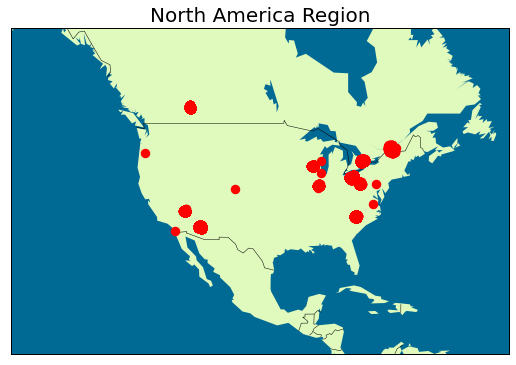

In [12]:
# coordinates range for North America
lon_min, lon_max = -150, -50
lat_min, lat_max = 10,60

plt.figure(figsize=(10,6))
m1 = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
             llcrnrlon=lon_min, urcrnrlon=lon_max, resolution='c')
plt.title("North America Region", fontsize = 20)
m1.fillcontinents(color='#e0fabe',lake_color='#006994')
m1.drawmapboundary(fill_color='#006994')    
m1.drawcountries(linewidth=0.5, color="black") 
m1_coords = m1(df_bus_res["longitude"].tolist(), df_bus_res["latitude"].tolist())
m1.scatter(m1_coords[0], m1_coords[1], s=20, c="red", lw=5, zorder=5)

Top 10 cities with highest number of restaurants:

In [13]:
df_bus_res['city_state'] = df_bus_res['city'] + ',' + df_bus_res['state']

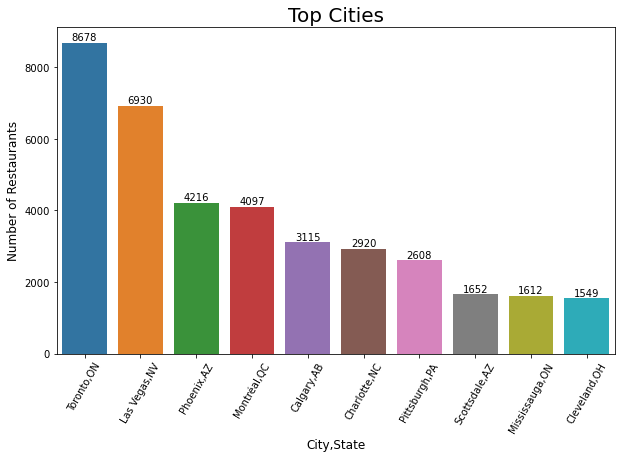

In [14]:
city_res_count = df_bus_res.city_state.value_counts()
city_res_count = city_res_count.sort_values(ascending = False)
city_res_count = city_res_count.iloc[0:10]

# plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(city_res_count.index, city_res_count.values)
plt.title("Top Cities",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 60)
plt.ylabel('Number of Restaurants', fontsize = 12)
plt.xlabel('City,State', fontsize = 12)

#text labels
r = ax.patches
labels = city_res_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

Let's look into Toronto and Las Vegas:

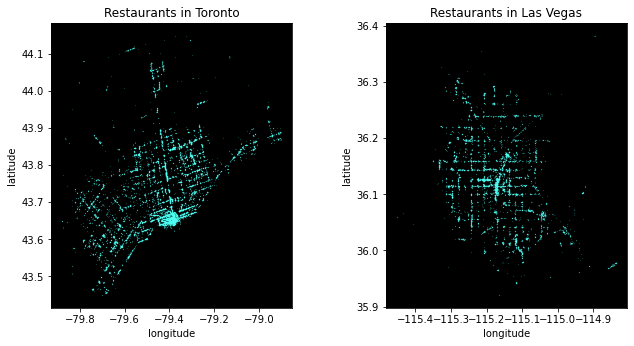

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

#coordinates for Toronto (Source: Google)
lat_t = 43.6532
lon_t = -79.3832

#rectangular view
lon_t_min, lon_t_max = lon_t-0.5,lon_t+0.5
lat_t_min, lat_t_max = lat_t-0.5,lat_t+0.5

#subset the data
df_res_tor=df_bus_res[(df_bus_res["longitude"]>lon_t_min) & (df_bus_res["longitude"]<lon_t_max) &\
                    (df_bus_res["latitude"]>lat_t_min) & (df_bus_res["latitude"]<lat_t_max)]

#plot
df_res_tor.plot(kind='scatter', x='longitude', y='latitude',
                color='#52fff3', s=0.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Restaurants in Toronto")
ax1.set_facecolor('black')

#coordinates for Las Vegas (Source: Google)
lat_v = 36.1699
lon_v = -115.1398

#rectangular view
lon_v_min, lon_v_max = lon_v-0.5,lon_v+0.5
lat_v_min, lat_v_max = lat_v-0.5,lat_v+0.5

#subset the data
df_res_lv=df_bus_res[(df_bus_res["longitude"]>lon_v_min) & (df_bus_res["longitude"]<lon_v_max) &\
                    (df_bus_res["latitude"]>lat_v_min) & (df_bus_res["latitude"]<lat_v_max)]

#plot
df_res_lv.plot(kind='scatter', x='longitude', y='latitude',
                color='#52fff3', s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Restaurants in Las Vegas")
ax2.set_facecolor('black')

f.tight_layout(pad=5.0);

Top common restaurants:

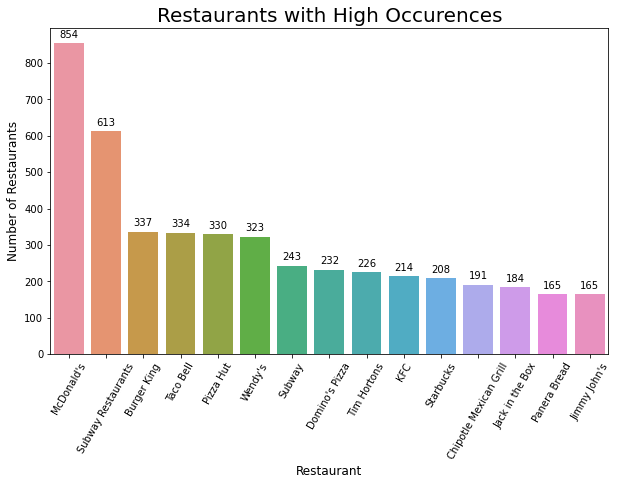

In [16]:
res_count = df_bus_res.name.value_counts()
res_count = res_count.sort_values(ascending = False)
res_count = res_count.iloc[0:15]

# plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(res_count.index, res_count.values)
plt.title("Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 60)
plt.ylabel('Number of Restaurants', fontsize = 12)
plt.xlabel('Restaurant', fontsize = 12)

#text labels
r = ax.patches
labels = res_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

In [17]:
df_bus_res.loc[df_bus_res.name == 'Subway', 'name'] = 'Subway Restaurants'

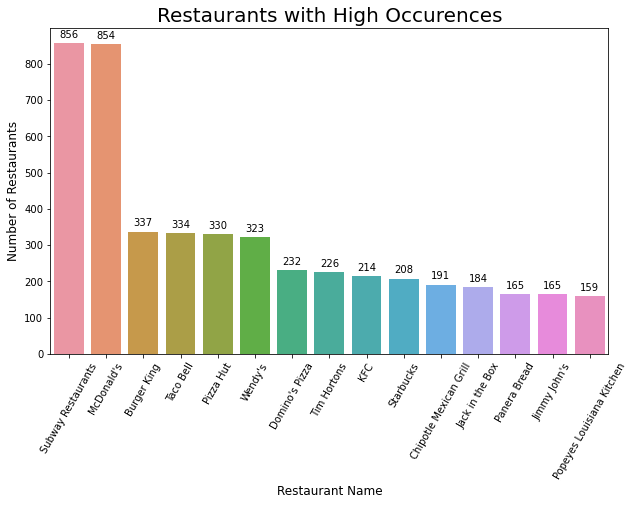

In [18]:
res_count = df_bus_res.name.value_counts()
res_count = res_count.sort_values(ascending = False)
res_count = res_count.iloc[0:15]

# plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(res_count.index, res_count.values)
plt.title("Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 60)
plt.ylabel('Number of Restaurants', fontsize = 12)
plt.xlabel('Restaurant Name', fontsize = 12)

#text labels
r = ax.patches
labels = res_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

Now let's compare ratings between some popular restaurant chains:

In [19]:
#subset data
sub_mb = df_bus_res.loc[(df_bus_res.name == 'McDonald\'s') | (df_bus_res.name == 'Burger King')]
sub_pd = df_bus_res.loc[(df_bus_res.name == 'Pizza Hut') | (df_bus_res.name == 'Domino\'s Pizza')]
sub_sj = df_bus_res.loc[(df_bus_res.name == 'Subway Restaurants') | (df_bus_res.name == 'Jimmy John\'s')]
sub_tc = df_bus_res.loc[(df_bus_res.name == 'Taco Bell') | (df_bus_res.name == 'Chipotle Mexican Grill')]

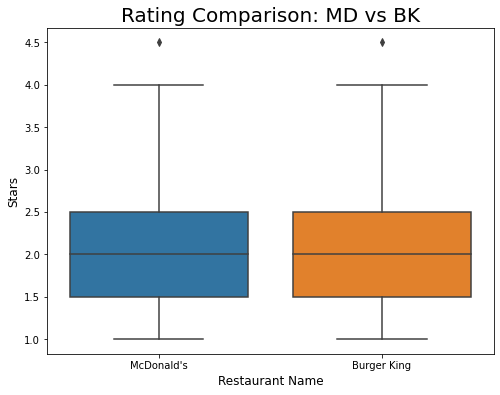

In [20]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x = 'name', y = 'stars', data = sub_mb)
plt.title("Rating Comparison: MD vs BK",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
plt.xlabel('Restaurant Name', fontsize = 12);

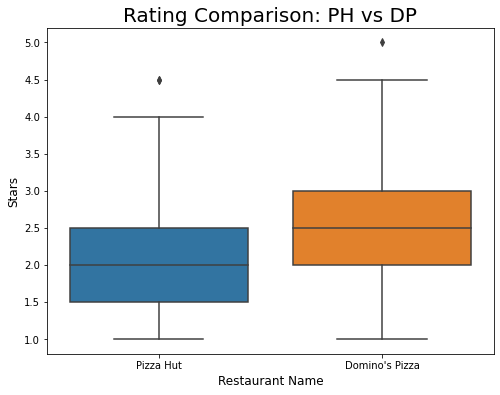

In [21]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x = 'name', y = 'stars', data = sub_pd)
plt.title("Rating Comparison: PH vs DP",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
plt.xlabel('Restaurant Name', fontsize = 12);

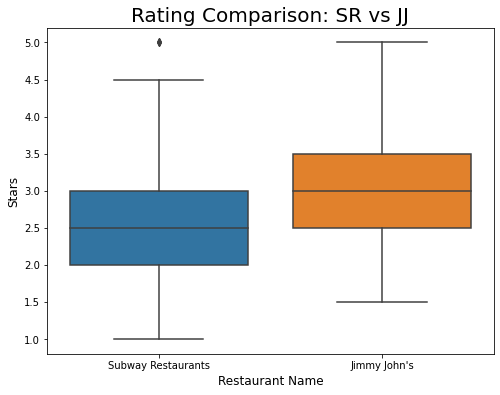

In [22]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x = 'name', y = 'stars', data = sub_sj)
plt.title("Rating Comparison: SR vs JJ",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
plt.xlabel('Restaurant Name', fontsize = 12);

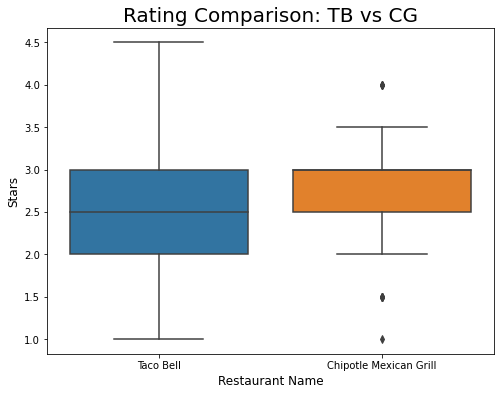

In [23]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x = 'name', y = 'stars', data = sub_tc)
plt.title("Rating Comparison: TB vs CG",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
plt.xlabel('Restaurant Name', fontsize = 12);

Let's check on Chipotle's median:

In [24]:
df_bus_res.loc[df_bus_res.name == 'Chipotle Mexican Grill'].stars.median()

3.0

How are ratings and review counts correlated?

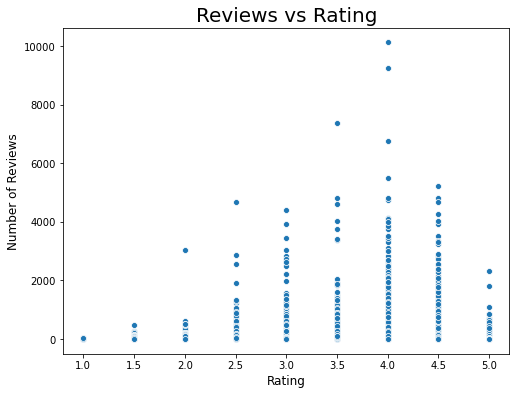

In [25]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'stars', y = 'review_count', data = df_bus_res)
plt.title("Reviews vs Rating",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Rating', fontsize = 12);

Now let's look at the attributes:

In [26]:
df_bus_res['attributes'] = df_bus_res['attributes'].apply(lambda x: {} if x is None else x)
df_att = pd.json_normalize(df_bus_res.attributes)

In [27]:
df_att.head()

,RestaurantsAttire,RestaurantsTakeOut,BusinessAcceptsCreditCards,NoiseLevel,GoodForKids,RestaurantsReservations,RestaurantsGoodForGroups,BusinessParking,RestaurantsPriceRange2,HasTV,...,BestNights,GoodForDancing,Smoking,BYOBCorkage,CoatCheck,AgesAllowed,RestaurantsCounterService,Open24Hours,AcceptsInsurance,HairSpecializesIn
0,u'casual',True,True,u'quiet',False,False,False,None,1,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,u'casual',True,True,NaN,True,False,True,"{'garage': False, 'street': False, 'validated'...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,True,NaN,NaN,NaN,False,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,True,NaN,NaN,True,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,True,NaN,NaN,NaN,True,NaN,"{'garage': False, 'street': True, 'validated':...",NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# attributes of restaurants
df_att.columns

Index(['RestaurantsAttire', 'RestaurantsTakeOut', 'BusinessAcceptsCreditCards',
       'NoiseLevel', 'GoodForKids', 'RestaurantsReservations',
       'RestaurantsGoodForGroups', 'BusinessParking', 'RestaurantsPriceRange2',
       'HasTV', 'Alcohol', 'BikeParking', 'RestaurantsDelivery',
       'ByAppointmentOnly', 'OutdoorSeating', 'RestaurantsTableService',
       'DogsAllowed', 'WiFi', 'Caters', 'Ambience', 'GoodForMeal', 'HappyHour',
       'WheelchairAccessible', 'BYOB', 'Corkage', 'DietaryRestrictions',
       'DriveThru', 'BusinessAcceptsBitcoin', 'Music', 'BestNights',
       'GoodForDancing', 'Smoking', 'BYOBCorkage', 'CoatCheck', 'AgesAllowed',
       'RestaurantsCounterService', 'Open24Hours', 'AcceptsInsurance',
       'HairSpecializesIn'],
      dtype='object')

In [29]:
df_att.BusinessAcceptsBitcoin.value_counts()

False    4245
True       74
Name: BusinessAcceptsBitcoin, dtype: int64

In [30]:
# price range vs coatcheck
pd.crosstab(df_att.RestaurantsPriceRange2, df_att.CoatCheck, margins=True, normalize = 'index')

CoatCheck,False,None,True
RestaurantsPriceRange2,,,
1,0.979540,0.000000,0.020460
2,0.934345,0.001139,0.064516
3,0.592308,0.000000,0.407692
4,0.489796,0.000000,0.510204
None,0.000000,0.000000,1.000000
All,0.905904,0.000899,0.093197


In [31]:
# stars vs delivery
pd.crosstab(df_bus_res.stars, df_att.RestaurantsDelivery, margins=True, normalize = 'index')

RestaurantsDelivery,False,None,True
stars,,,
1.0,0.581967,0.049180,0.368852
1.5,0.593434,0.017677,0.388889
2.0,0.641283,0.010020,0.348697
2.5,0.596458,0.018343,0.385199
3.0,0.623143,0.014162,0.362694
3.5,0.625852,0.017567,0.356581
4.0,0.605974,0.020260,0.373766
4.5,0.627789,0.014706,0.357505
5.0,0.608802,0.002445,0.388753


Take a look at Toronto:

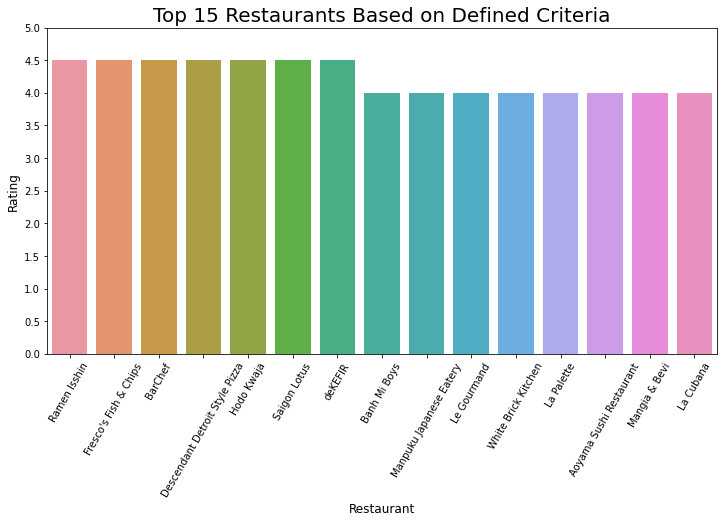

In [32]:
df_tor = df_bus_res.loc[df_bus_res['city'] == 'Toronto']

# open restaurants more than 100 reviews with rating above 3.5, accepts takeout, credit cards, and price range of $$.
crit = (df_tor['stars'] > 3.5) & (df_tor['review_count'] > 100) & (df_tor['is_open'] == 1) & (df_att.RestaurantsTakeOut == 'True') & (df_att.RestaurantsPriceRange2 == '2') & (df_att.BusinessAcceptsCreditCards == 'True')
df_tor_sub = df_tor.loc[crit]
fig = plt.figure(figsize=(12, 6))
sns.barplot(x = 'name', y = 'stars', data = df_tor_sub.sort_values(by=['stars', 'review_count'], ascending = False)[0:15])
plt.title("Top 15 Restaurants Based on Defined Criteria",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 60)
plt.yticks(np.arange(0.0, 5.5, 0.5))
plt.ylabel('Rating', fontsize = 12)
plt.xlabel('Restaurant', fontsize = 12);

In [33]:
df_tor_sub.sort_values(by=['stars', 'review_count'], ascending = False)[0:15]['name']

28918                      Ramen Isshin
46423             Fresco's Fish & Chips
49260                           BarChef
37688    Descendant Detroit Style Pizza
4472                         Hodo Kwaja
49245                      Saigon Lotus
27989                           deKEFIR
60497                      Banh Mi Boys
30969           Manpuku Japanese Eatery
16129                       Le Gourmand
2827                White Brick Kitchen
30799                        La Palette
43941           Aoyama Sushi Restaurant
4794                      Mangia & Bevi
4136                          La Cubana
Name: name, dtype: object

First, load the tips data and review data:

In [34]:
tips = []
with open('../input/yelp-dataset/yelp_academic_dataset_tip.json') as fl:
    for i, line in enumerate(fl):
        tips.append(json.loads(line))
df_tips = pd.DataFrame(tips)

# print the first five rows
df_tips.head()

,user_id,business_id,text,date,compliment_count
0,hf27xTME3EiCp6NL6VtWZQ,UYX5zL_Xj9WEc_Wp-FrqHw,Here for a quick mtg,2013-11-26 18:20:08,0
1,uEvusDwoSymbJJ0auR3muQ,Ch3HkwQYv1YKw_FO06vBWA,Cucumber strawberry refresher,2014-06-15 22:26:45,0
2,AY-laIws3S7YXNl_f_D6rQ,rDoT-MgxGRiYqCmi0bG10g,Very nice good service good food,2016-07-18 22:03:42,0
3,Ue_7yUlkEbX4AhnYdUfL7g,OHXnDV01gLokiX1ELaQufA,It's a small place. The staff is friendly.,2014-06-06 01:10:34,0
4,LltbT_fUMqZ-ZJP-vJ84IQ,GMrwDXRlAZU2zj5nH6l4vQ,"8 sandwiches, $24 total...what a bargain!!! An...",2011-04-08 18:12:01,0


In [35]:
df_RI = df_bus_res.loc[(df_bus_res['name'] == 'Ramen Isshin') & crit]
df_RI_tips = df_tips.loc[df_tips['business_id'].isin(df_RI.business_id)]

In [36]:
df_RI_tips.text.values[0:10]

array(["Very small place fits about 30 people. They don't quite have a big sign.",
       'Liquor license coming soon.',
       "Try the soft tofu appetizer! It's quite light but I find it really tasty!",
       'They have a really cool chart in the front of their menu that breaks down each dish!',
       'For the gluten intolerant rice noodles are an option!!',
       'Order the white sesame ramen! Quite tasty!',
       'By far, the most spacious ramenya in Toronto.',
       'If you want to "kaedama" (get an extra portion of noodles) it\'s $1.50.  Totally worth it if you\'re a big eater or extra hungry!  :)',
       'Their spicy sauce is really good i got something similar when i was in Japan',
       "Mouth wash is the washrooms!  Now we can make our breath fresh again after eating! Isn't it a good idea?"],
      dtype=object)

To process its tips, first need to define a helper function to process raw text

In [37]:
def text_prep(text):
    # filer out non-letters and lowercase them
    text = re.sub('[^a-z\s]', '', text.lower())
    # remove stopwords
    text = [w for w in text.split() if w not in stopwords.words('english')]
    return ' '.join(text)

In [38]:
pd.set_option('mode.chained_assignment', None)
df_RI_tips['text_cl'] = df_RI_tips['text'].apply(text_prep)

Creat a Word Cloud for its tips

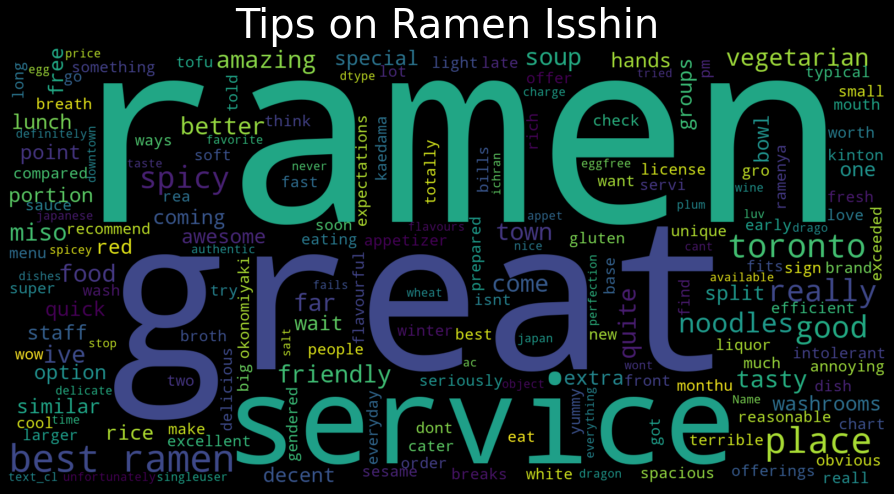

In [39]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000)

# generation
wc.generate(str(df_RI_tips['text_cl']))

plt.figure(figsize=(15,10), facecolor='black')
plt.title("Tips on Ramen Isshin", fontsize=40, color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

Fresco's fish and chips:

In [40]:
df_FFC = df_bus_res.loc[(df_bus_res['name'] == 'Fresco\'s Fish & Chips') & crit]
df_FFC_tips = df_tips.loc[df_tips['business_id'].isin(df_FFC.business_id)]

In [43]:
df_FFC_tips.text.values[0:10]

array(['Check in for a free drink!!',
       'Therea a great love for The Beatles here from memorabilia to the music playing. :)',
       'Check-in here with Yelp, and you can get a free drink!',
       '$2 for Haddock on a stick.',
       'Sunday! 3 items for just $5! I like the shrimp!',
       'Add extra fish for only a few dollars, great for sharing!',
       'Yummy, the best!',
       "Ask to add extra piece of fish to order if you don't want too many chips but want two orders; more fish less chips less money. ;)",
       'For all you vegans out there. Mushroom gravy on the side for my vegetarian wife.\n\nOpen the box and lay it flat for easy access.\n\nHalibut and chips with extra batter salt and vinegar ms vikki chips.',
       'Use the free drink checking offer!'], dtype=object)

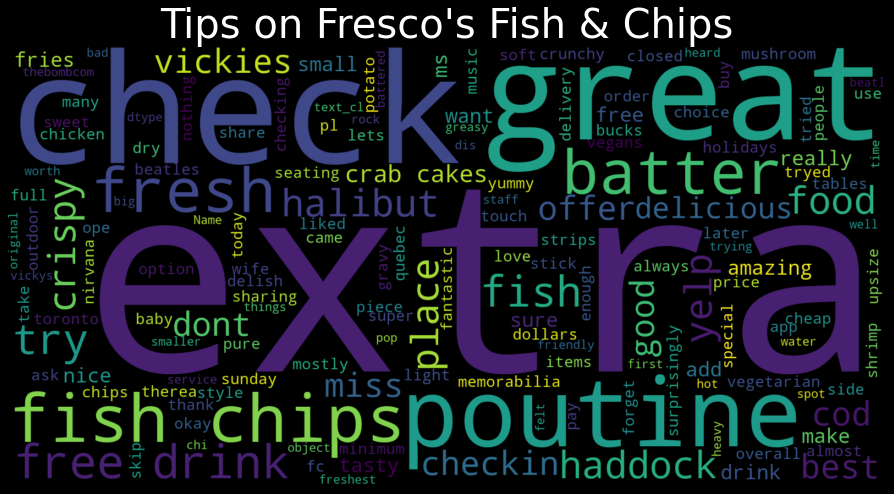

In [42]:
pd.set_option('mode.chained_assignment', None)
df_FFC_tips['text_cl'] = df_FFC_tips['text'].apply(text_prep)

wc = WordCloud(width=1600, height=800, random_state=42, max_words=20000)

# generation
wc.generate(str(df_FFC_tips['text_cl']))

plt.figure(figsize=(15,10), facecolor='black')
plt.title("Tips on Fresco\'s Fish & Chips", fontsize=40, color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)